In [1]:
%load_ext autoreload
%autoreload 2
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import matplotlib.pyplot as plt
from os.path import dirname
import os
from tqdm import tqdm
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names, response_utils
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import neuro.config
import seaborn as sns
from neuro.features.questions.gpt4 import QS_35_STABLE
import numpy as np
import joblib
from collections import defaultdict
from os.path import join
from sklearn.metrics import balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from neuro import analyze_helper
import dvu
import sasc.viz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from neuro.analyze_helper import abbrev_question
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pickle")
import decode
dvu.set_style()
data_dir = join(neuro.config.repo_dir, 'data', 'decoding')

### Plot decoding acc

mean mean acc 0.6769636054332193
uts01 mean acc 0.6554084523331226
uts02 mean acc 0.6846794862854867
uts03 mean acc 0.6908028776810486


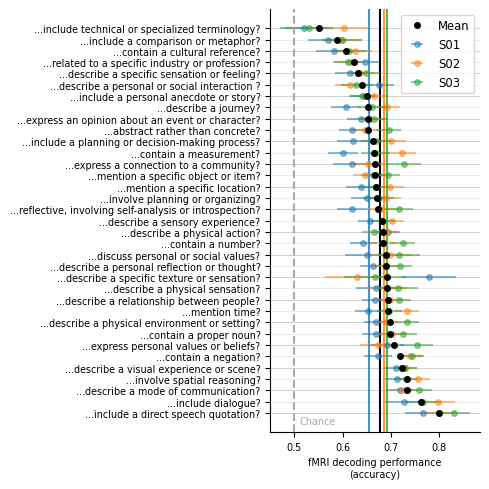

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
colors = {
    'uts01': 'C0',
    'uts02': 'C1',
    'uts03': 'C2',
    'mean': 'black'
}
metric = 'test_acc'
# metric = 'test_acc_ood'
for subject in ['mean', 'uts01', 'uts02', 'uts03']:
    r_df = decode._load_result(subject)
    if subject == 'mean':
        idx_sort = r_df[metric].sort_values(ascending=False).index

    r_df = r_df.loc[idx_sort]
    r_df = r_df[r_df['label'].isin(QS_35_STABLE)]

    # plot accuracy with binomial error bars
    if subject == 'mean':
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            color='black',
            fmt='o',
            ms=4,
            zorder=1000,
            label=subject.capitalize().replace('UT', ''),
        )
        plt.axvline(r_df[metric].mean(), color=colors[subject])
    else:
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            xerr=np.sqrt(
                r_df[metric] * (1-r_df[metric])
                / r_df['num_test']),
            alpha=0.5,
            label=subject.upper().replace('UT', ''),
            fmt='o',
            ms=4,
        )
        plt.axvline(r_df[metric].mean(),
                    linestyle='-', color=colors[subject], alpha=0.8)

    print(subject, 'mean acc', r_df[metric].mean())

fs = 'x-small'
# add horizontal bars
labs = [analyze_helper.abbrev_question(q) for q in r_df['label']]
plt.yticks(range(len(r_df)), labs, fontsize=fs)
plt.xlabel(
    'fMRI decoding performance\n(accuracy)', fontsize=fs)
plt.xticks(fontsize=fs)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# Get the current tick locations
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Select every other tick
# ax.set_xticks(xticks[::2])
ax.set_yticks(yticks[::2], minor=True)
ax.grid(True, which='major', linewidth=0.7, alpha=0.6, axis='y')

for i, line in enumerate(ax.yaxis.get_gridlines()):
    if i % 2 == 1:  # Hide every second gridline
        line.set_alpha(0.25)


# annotate with baseline and text label
plt.axvline(0.5, color='darkgray', linestyle='--')
plt.text(0.51, -1, 'Chance', color='darkgray', fontsize=fs, ha='left')
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig('linear_decoding.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
r_df = decode._load_result(subject)
r_df = r_df.loc[idx_sort]
r_df = r_df[r_df['label'].isin(QS_35_STABLE)]
print(r_df['label'].values.tolist())

['Does the sentence include a direct speech quotation?', 'Does the sentence include dialogue?', 'Does the text describe a mode of communication?', 'Does the sentence involve spatial reasoning?', 'Does the sentence describe a visual experience or scene?', 'Does the sentence contain a negation?', 'Does the sentence involve an expression of personal values or beliefs?', 'Does the sentence contain a proper noun?', 'Does the sentence involve a description of physical environment or setting?', 'Is time mentioned in the input?', 'Does the sentence describe a relationship between people?', 'Does the sentence describe a physical sensation?', 'Does the input describe a specific texture or sensation?', 'Does the sentence describe a personal reflection or thought?', 'Does the sentence involve a discussion about personal or social values?', 'Does the input contain a number?', 'Does the sentence describe a physical action?', 'Does the sentence describe a sensory experience?', 'Is the sentence reflec

### Visualize decoding weight flatmaps (and plot with encoding)

In [15]:
for subject in ['uts01', 'uts02', 'uts03']:
    # subject = 'uts03'
    pca_comps = joblib.load(join(data_dir, f'{subject}/pca_components.pkl'))
    # vertically stack pca_comps 4 times
    pca_comps = np.vstack([pca_comps]*4)
    r_df = decode._load_result(subject)

    for i in tqdm(range(len(r_df))):
        pc_coef = r_df.iloc[i]['coef']
        question = r_df.iloc[i]['label']
        if question not in QS_35_STABLE:
            continue
        voxel_coefs = (pc_coef @ pca_comps).squeeze()
        sasc.viz.quickshow(
            voxel_coefs,
            subject.upper(),
            with_colorbar=False,
            fname_save=join(data_dir, 'flatmaps_decoding', subject, f'{question}.pdf'))

  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [02:58<00:00,  2.21s/it]


In [ ]:
fnames_arr = []

# make grid of plots
nrows = 6
ncols = 35
axes = plt.subplots(nrows=nrows, ncols=ncols,
                    figsize=(4.5 * ncols, 3 * nrows))[1]

for i, subject in enumerate(['uts01', 'uts02', 'uts03']):
    for j, label in enumerate(tqdm(QS_35_STABLE)):
        fname = join(data_dir, 'flatmaps_decoding', subject, f'{label}.png')
        axes[i, j].imshow(mpimg.imread(fname))
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(abbrev_question(label), fontsize='x-small')
        if j == 0:
            # axes[i, j].set_ylabel(
            # subject.upper() + ' Decode', fontsize='x-small')
            # show rotated text where ylabel would be
            axes[i, j].text(-0.5, 0.5, subject.upper() + ' Decode',
                            fontsize='x-small', rotation=90, ha='center', va='center')

        fname_enc = join(repo_dir, 'qa_results', 'figs',
                         'flatmaps_export', subject.upper().replace('UT', ''), label + '.png')
        axes[3 + i, j].imshow(mpimg.imread(fname_enc))
        axes[3 + i, j].axis('off')
        if j == 0:
            # axes[3 + i, j].set_ylabel(subject.upper() +
            #   ' Encode', fontsize='x-small')
            # show rotated text where ylabel would be
            axes[3 + i, j].text(-0.5, 0.5, subject.upper() + ' Encode',
                                fontsize='x-small', rotation=90, ha='center', va='center')

plt.savefig(join(data_dir, 'flatmaps_decoding', 'all.pdf'))  # , dpi=300)
# for subject in ['uts01', 'uts02', 'uts03']:

### Compare enc/dec flatmaps

In [9]:
corrs = defaultdict(list)
flatmaps = defaultdict(list)
for subject in ['S01', 'S02', 'S03']:
    subject_dec = 'ut' + subject.lower()

    # subject = 'uts03'
    pca_comps = joblib.load(
        join(data_dir, f'{subject_dec}/pca_components.pkl'))
    # vertically stack pca_comps 4 times
    pca_comps = np.vstack([pca_comps]*4)
    r_df = decode._load_result(subject_dec).set_index(
        'label').loc[QS_35_STABLE]

    for i, q in tqdm(enumerate(QS_35_STABLE)):

        settings = ['individual_gpt4_pc_new']
        flatmap_qa = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), 'individual_gpt4_pc_new.pkl'))
        flatmaps[subject + '_enc'].append(flatmap_qa[q])

        pc_coef = r_df.iloc[i]['coef']
        flatmap_decode = (pc_coef @ pca_comps).squeeze()
        flatmaps[subject + '_dec'].append(flatmap_decode)

        corrs[subject].append(
            np.corrcoef(flatmap_decode, flatmap_qa[q])[0, 1])

35it [00:00, 66.74it/s]
35it [00:00, 65.20it/s]
35it [00:00, 66.56it/s]


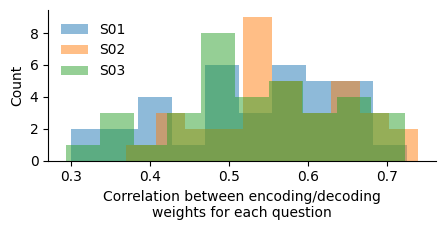

In [12]:
plt.figure(figsize=(3.8*1.2, 2*1.2))
for subj in ['S01', 'S02', 'S03']:
    plt.hist(corrs[subj], alpha=0.5, label=subj)
plt.legend(frameon=False)
plt.xlabel('Correlation between encoding/decoding\nweights for each question')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(join(repo_dir, 'qa_results', 'figs',
            'enc_dec_hist.png'), dpi=500, bbox_inches='tight')
plt.show()

In [9]:
np.mean(np.array(list(corrs.values())))

np.float64(0.5450792915244819)

In [ ]:
for k in flatmaps.keys():
    #     arr = np.array(flatmaps[k]).mean(axis=0)
    # # arr_enc = np.array(flatmaps['S02_enc']).mean(axis=0)
    # # arr_dec = np.array(flatmaps['S02_dec']).mean(axis=0)
    # # , fname_save=join(data_dir, 'flatmaps_decoding', 'S02_enc.png'))
    #     sasc.viz.quickshow(arr, 'UT' + k.split('_')[0], fname_save=join(
    #         data_dir, 'flatmaps_decoding', 'avgs', 'avg_' + k + '.png'),
    #         with_colorbar=False,)

    arr_abs = np.abs(np.array(flatmaps[k])).mean(axis=0)
    sasc.viz.quickshow(arr_abs, 'UT' + k.split('_')[0], fname_save=join(
        data_dir, 'flatmaps_decoding', 'avgs', 'avg_abs_' + k + '.png'),
        with_colorbar=False,)

In [ ]:
# read the pngs into a grid
# subjects = ['S01', 'S02', 'S03']
subjects = ['S03']
nrows = len(subjects)
ncols = 2
axes = plt.subplots(nrows=nrows, ncols=ncols,
                    figsize=(4 * ncols, 2 * nrows))[1]
for i, subject in enumerate(subjects):
    fname = join(data_dir, 'flatmaps_decoding', 'avg_' + subject + '_enc.png')
    axes[i, 0].imshow(mpimg.imread(fname))
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('Encoding', fontsize='x-small')
    # axes[i, 0].set_ylabel(subject.upper(), fontsize='x-small')
    # show rotated text where ylabel would be
    axes[i, 0].text(-0.5, -20, subject.upper(),
                    fontsize='x-small', rotation=90, ha='center', va='center')

    fname = join(data_dir, 'flatmaps_decoding', 'avg_' + subject + '_dec.png')
    axes[i, 1].imshow(mpimg.imread(fname))
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('Decoding', fontsize='x-small')
plt.tight_layout()
plt.savefig(join(data_dir, 'flatmaps_decoding', 'avg_enc_dec.png'), dpi=300)

### Ablated dec perf

In [2]:
fnames = [f for f in os.listdir(
    join(data_dir, 'test_acc')) if f.startswith('r_df')]
r_dfs = []
for fname in fnames:
    r_df = pd.DataFrame(joblib.load(join(data_dir, 'test_acc', fname))
                        [['test_acc']].mean())
    r_df['fname'] = fname.replace('.pkl', '').replace('r_df_ut', '')
    r_dfs.append(r_df)
df = pd.concat(r_dfs)
df.rename(columns={0: 'acc'}, inplace=True)

df['subject'] = df['fname'].str.split('_').str[0].str.upper()
df['shuffle'] = df['fname'].str.contains('shuffle')
df['fname'] = df['fname'].str.replace('_shuffle', '')


def get_nvoxels(fname):
    if 'nvoxels' in fname:
        return int(fname.split('=')[-1])
    else:
        return 100000


df['nvoxels'] = df['fname'].apply(get_nvoxels)

# add mean subject
df_mean = df.groupby(['shuffle', 'nvoxels'])['acc'].mean().reset_index()
df_mean['subject'] = 'Mean'
df = pd.concat([df, df_mean])

# look up nvoxels in df


def _rewrite_nvoxels(row):
    nvoxels, subj = row['nvoxels'], row['subject']
    if nvoxels == 100000:
        return neuro.config.VOX_COUNTS[subj]
    else:
        return nvoxels


df['nvoxels'] = df.apply(_rewrite_nvoxels, axis=1)
df['shuffle'] = df['shuffle'].replace({False: 'Selected', True: 'Random'})

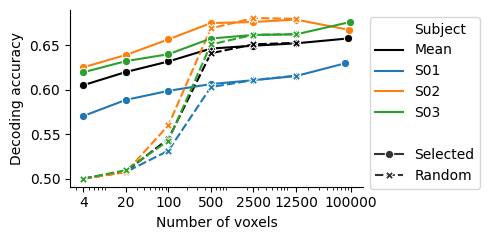

In [3]:

df = df.rename(columns={'subject': 'Subject', 'shuffle': ' '})
plt.figure(figsize=(5, 2.5))
sns.lineplot(data=df, x='nvoxels',
             y='acc', hue='Subject', style=' ', markers=True,
             hue_order=['Mean', 'S01', 'S02', 'S03'],
             palette=['black', 'C0', 'C1', 'C2'],
             style_order=['Selected', 'Random'],
             )
plt.ylabel('Decoding accuracy')
plt.xlabel('Number of voxels')
plt.xscale('log')

# move legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# set tick labels at 20, 100, 500, 2500, 100000
plt.xticks([4, 20, 100, 500, 2500, 12500, 100000],
           ['4', '20', '100', '500', '2500', '12500', '100000'])
plt.tight_layout()
plt.savefig(join(data_dir, 'dec_acc_by_voxels.png'), dpi=300)

plt.show()

In [4]:
df

,acc,fname,Subject,,nvoxels
test_acc,0.499880,s01_nvoxels=4,S01,Random,4
test_acc,0.640053,s03_nvoxels=100,S03,Selected,100
test_acc,0.610889,s01_nvoxels=2500,S01,Random,2500
test_acc,0.656795,s02_nvoxels=100,S02,Selected,100
test_acc,0.662726,s03_nvoxels=12500,S03,Random,12500
test_acc,0.662382,s03_nvoxels=12500,S03,Selected,12500
test_acc,0.661792,s03_nvoxels=2500,S03,Selected,2500
test_acc,0.560005,s02_nvoxels=100,S02,Random,100
test_acc,0.676194,s03,S03,Selected,95556
test_acc,0.615447,s01_nvoxels=12500,S01,Selected,12500
